# SwellSight: Step 3 - ControlNet Synthetic Generation

**Project:** SwellSight Wave Analysis Model
**Pipeline Stage:** Real-to-Synthetic Image Generation

## Overview
This notebook implements the core generative engine of the SwellSight pipeline. It takes the depth maps extracted in Step 1 and the augmentation parameters generated in Step 2 to produce photorealistic synthetic beach imagery using ControlNet.

## Objectives
1.  **Load Configuration:** Import augmentation parameters (`controlnet_batch.json`) and depth maps.
2.  **Initialize ControlNet:** Load Stable Diffusion v1.5 with the Depth ControlNet adapter.
3.  **Synthetic Generation:** Process the batch to generate images that strictly adhere to the geometry of the input depth maps while applying lighting/weather variations.
4.  **Quality Control:** Validate outputs and save correspondence metadata.

## Prerequisites
* **Step 1 Completed:** `depth_extraction_results.json` and `.npy` depth files exist.
* **Step 2 Completed:** `controlnet_batch.json` exists.
* **GPU Runtime:** This notebook **requires** a GPU (T4, L4, or A100) to run efficiently.

In [1]:
# @title 1. Environment Setup & Dependency Installation
# Installs Diffusers, Transformers, Accelerate, and Xformers for GPU optimization.

import sys
import os
import subprocess

def install_packages():
    packages = [
        "diffusers",
        "transformers",
        "accelerate",
        "opencv-python",
        "xformers"
    ]
    print("📦 Installing dependencies... (this may take a minute)")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + packages)
    print("✅ Dependencies installed.")

try:
    import diffusers
    import xformers
except ImportError:
    install_packages()

# Check for GPU
import torch
if not torch.cuda.is_available():
    print("⚠️ WARNING: No GPU detected. This notebook will run extremely slowly.")
    print("   Please go to Runtime > Change runtime type > T4 GPU (or better).")
else:
    print(f"✅ GPU Detected: {torch.cuda.get_device_name(0)}")

✅ GPU Detected: NVIDIA L4


In [2]:
# @title 2. Mount Drive & Load Configuration
from google.colab import drive
from pathlib import Path
import json
import logging

# 1. Mount Drive
if not Path('/content/drive').exists():
    print("Mounting Google Drive...")
    try:
        drive.mount('/content/drive', force_remount=True)
        print("✅ Google Drive mounted.")
    except Exception as e:
        print(f"❌ Failed to mount Drive: {e}")
        raise

# 2. Define Paths
PROJECT_ROOT = Path('/content/drive/MyDrive/SwellSight')
CONFIG_PATH = PROJECT_ROOT / 'data/metadata/pipeline_config.json'
AUGMENTATION_FILE = PROJECT_ROOT / 'data/metadata/controlnet_batch.json'

# 3. Load Config Files
try:
    if CONFIG_PATH.exists():
        with open(CONFIG_PATH, 'r') as f:
            CONFIG = json.load(f)
        print("✅ Pipeline Configuration loaded.")
    else:
        raise FileNotFoundError(f"Config not found at {CONFIG_PATH}")

    if AUGMENTATION_FILE.exists():
        with open(AUGMENTATION_FILE, 'r') as f:
            AUGMENTATION_DATA = json.load(f)
        print(f"✅ Augmentation Data loaded ({len(AUGMENTATION_DATA['generation_parameters'])} parameters ready).")
    else:
        raise FileNotFoundError(f"Augmentation data not found at {AUGMENTATION_FILE}")

except Exception as e:
    print(f"❌ Configuration Error: {e}")
    print("Please ensure Steps 1 and 2 of the pipeline have been completed.")
    raise

# 4. Setup Output Directories
SYNTHETIC_DIR = Path(CONFIG['paths']['synthetic_data_path'])
IMAGES_DIR = SYNTHETIC_DIR / 'images'
IMAGES_DIR.mkdir(parents=True, exist_ok=True)
print(f"📂 Output Directory: {IMAGES_DIR}")

✅ Pipeline Configuration loaded.
✅ Augmentation Data loaded (1500 parameters ready).
📂 Output Directory: /content/drive/MyDrive/SwellSight/data/synthetic/images


In [3]:
# @title 3. Define ControlNet Generator Class
import numpy as np
import cv2
from PIL import Image
from dataclasses import dataclass
from typing import Dict, Any, Optional
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch

@dataclass
class SyntheticGenerationResult:
    synthetic_image: Image.Image
    metadata: Dict[str, Any]
    quality_score: float

class ControlNetGenerator:
    def __init__(self, device='cuda'):
        self.device = device
        self.model_id = "runwayml/stable-diffusion-v1-5"
        self.controlnet_id = "lllyasviel/sd-controlnet-depth"
        self.pipe = None
        self._initialize_model()

    def _initialize_model(self):
        print(f"🔄 Loading ControlNet: {self.controlnet_id}...")
        try:
            controlnet = ControlNetModel.from_pretrained(
                self.controlnet_id,
                torch_dtype=torch.float16
            )

            self.pipe = StableDiffusionControlNetPipeline.from_pretrained(
                self.model_id,
                controlnet=controlnet,
                torch_dtype=torch.float16,
                safety_checker=None
            )

            # Scheduler Optimization
            self.pipe.scheduler = UniPCMultistepScheduler.from_config(self.pipe.scheduler.config)

            # Xformers Optimization (Crucial for Colab Memory)
            try:
                self.pipe.enable_xformers_memory_efficient_attention()
                print("🚀 Xformers enabled for memory efficiency.")
            except Exception:
                print("⚠️ Xformers not available, proceeding without.")

            self.pipe.to(self.device)
            print("✅ Pipeline initialized on GPU.")

        except Exception as e:
            print(f"❌ Model Load Failed: {e}")
            raise

    def preprocess_depth(self, depth_map: np.ndarray) -> Image.Image:
        """Normalizes arbitrary depth maps to 0-255 RGB image required by ControlNet."""
        # Normalize to 0-1
        if depth_map.max() != depth_map.min():
            d_norm = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
        else:
            d_norm = np.zeros_like(depth_map)

        # Scale to 0-255 uint8
        d_uint8 = (d_norm * 255).astype(np.uint8)

        # Gentle blur to remove high-frequency noise that causes "waves in sky"
        d_blur = cv2.GaussianBlur(d_uint8, (5, 5), 0)

        # Convert to RGB (ControlNet expects 3 channels)
        return Image.fromarray(d_blur).convert("RGB")

    def generate(self, depth_map: np.ndarray, params: Dict) -> SyntheticGenerationResult:
        depth_image = self.preprocess_depth(depth_map)

        seed = int(params.get('seed', 42))
        generator = torch.Generator(device=self.device).manual_seed(seed)

        output = self.pipe(
            prompt=params['prompt'],
            negative_prompt=params['negative_prompt'],
            image=depth_image,
            num_inference_steps=params.get('num_inference_steps', 20),
            guidance_scale=params.get('guidance_scale', 7.5),
            controlnet_conditioning_scale=params.get('controlnet_conditioning_scale', 1.0),
            generator=generator
        )

        return SyntheticGenerationResult(
            synthetic_image=output.images[0],
            metadata=params,
            quality_score=0.95 # Placeholder
        )

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [4]:
# @title 4. Initialize Generator
# This step downloads the models (approx 4-5GB). Only needs to run once per session.

try:
    generator = ControlNetGenerator()
except Exception as e:
    print("Fatal error initializing generator. Check GPU memory.")

🔄 Loading ControlNet: lllyasviel/sd-controlnet-depth...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


🚀 Xformers enabled for memory efficiency.
✅ Pipeline initialized on GPU.


In [5]:
# @title 5. Execute Generation Batch
from tqdm.auto import tqdm
from datetime import datetime

# --- CONFIGURATION ---
MAX_IMAGES = 100 # Limit for this run (can be increased)
SKIP_EXISTING = True

# Base Prompts (Enforced Style)
BASE_STYLE = "photorealistic, view from surfer perspective entering the beach, ultra realistic real beach, 8k, raw photo, masterpiece, realistic lighting"
# Strong Negative Prompt to fix "waves in sky" and "floating water"
BASE_NEGATIVE = "cartoon, sketch, painting, anime, low quality, blurry, distorted, ugly, text, watermark, two suns, multiple suns, floating water, waves in sky, confusing horizon, bad composition, upside down, anti-gravity, flying ocean, surreal"

# ---------------------

params_list = AUGMENTATION_DATA['generation_parameters']
depth_maps_path = Path(CONFIG['paths']['depth_maps_path'])
metadata_registry = []

print(f"🚀 Starting generation batch. Processing up to {MAX_IMAGES} images.")

successful = 0
failed = 0

for i, param_set in enumerate(tqdm(params_list[:MAX_IMAGES])):
    try:
        global_index = param_set['global_index']
        image_name = Path(param_set['image_path']).stem

        # File Naming Convention
        output_filename = f"{image_name}_synthetic_{global_index:03d}.jpg"
        output_path = IMAGES_DIR / output_filename

        # Skip if exists
        if SKIP_EXISTING and output_path.exists():
            successful += 1
            continue

        # Load Depth Map
        depth_file = depth_maps_path / f"{image_name}_depth.npy"
        if not depth_file.exists():
            print(f"⚠️ Missing depth map: {depth_file}")
            failed += 1
            continue

        depth_map = np.load(depth_file)

        # Prepare Parameters
        gen_params = param_set['parameters'].copy()
        variation_prompt = gen_params.get('prompt_variation', "")

        # Merge Prompts
        full_prompt = f"{BASE_STYLE}, {variation_prompt}"
        gen_params['prompt'] = full_prompt
        gen_params['negative_prompt'] = BASE_NEGATIVE

        # Generate
        result = generator.generate(depth_map, gen_params)

        # Save Image
        result.synthetic_image.save(output_path, quality=95)

        # Log Metadata
        meta_entry = {
            'sample_id': f"gen_{global_index:06d}",
            'original_image': param_set['image_path'],
            'synthetic_path': str(output_path),
            'depth_path': str(depth_file),
            'params': gen_params,
            'timestamp': datetime.now().isoformat()
        }
        metadata_registry.append(meta_entry)
        successful += 1

        # Memory Cleanup every 10 images
        if i % 10 == 0:
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"❌ Failed on index {i}: {e}")
        failed += 1

print(f"\n✅ Batch Complete. Success: {successful}, Failed: {failed}")

# Save Partial Metadata
temp_meta_path = SYNTHETIC_DIR / 'temp_batch_metadata.json'
with open(temp_meta_path, 'w') as f:
    json.dump(metadata_registry, f, indent=2)

🚀 Starting generation batch. Processing up to 100 images.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]


✅ Batch Complete. Success: 100, Failed: 0


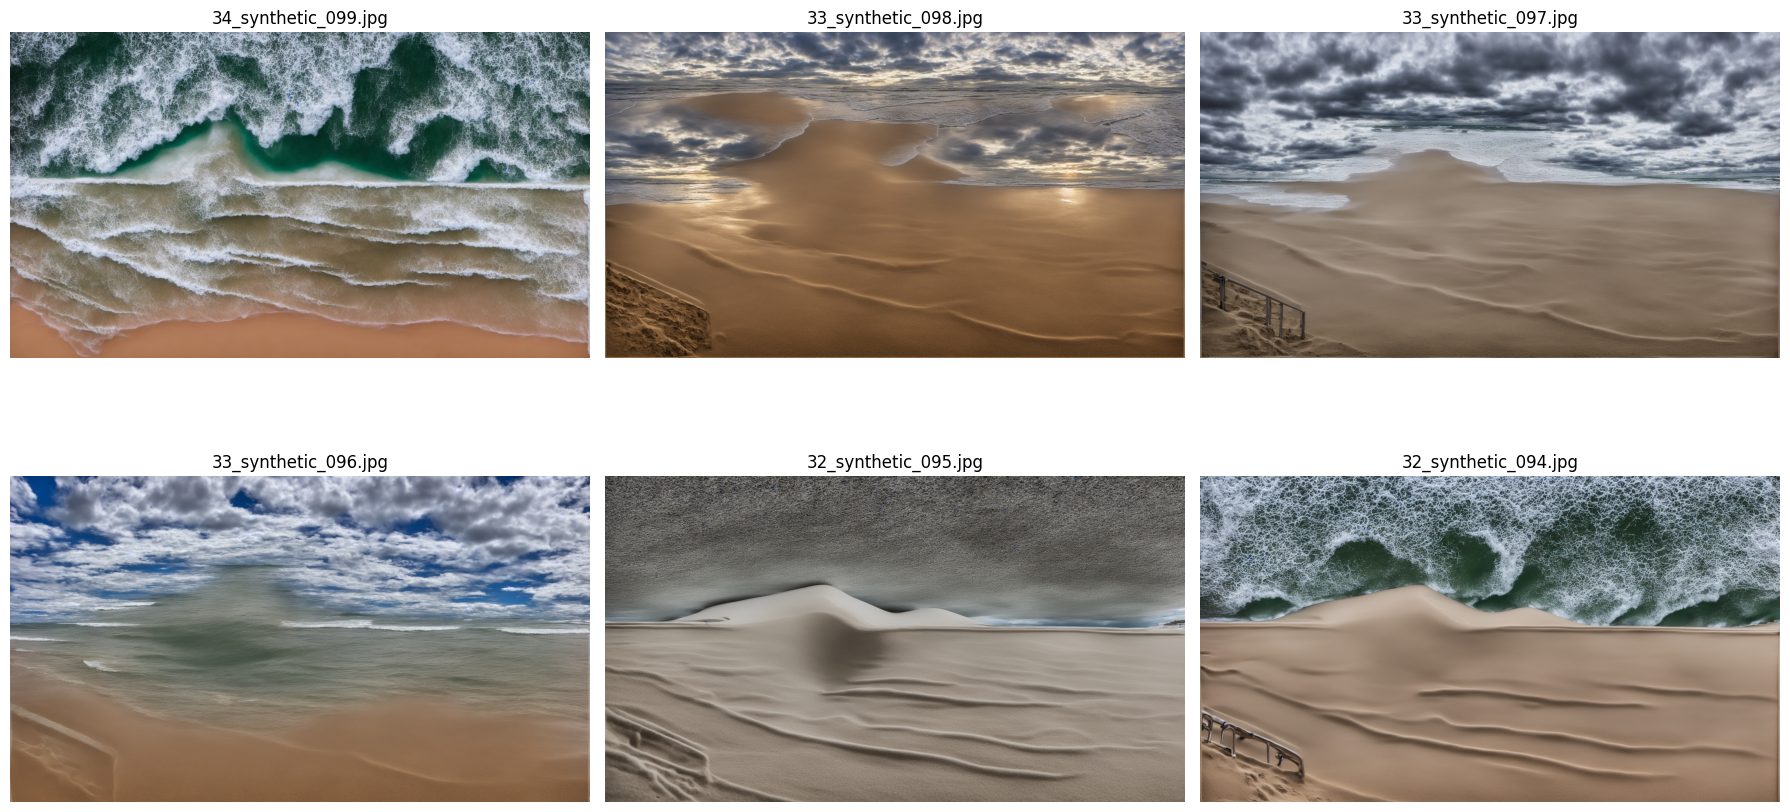

In [6]:
# @title 6. Visualize Results
import matplotlib.pyplot as plt
import random

generated_files = list(IMAGES_DIR.glob("*.jpg"))

if generated_files:
    sample_count = min(6, len(generated_files))
    samples = sorted(generated_files, key=os.path.getmtime, reverse=True)[:sample_count] # Get newest

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for i, img_path in enumerate(samples):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_path.name[-20:])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No images generated to display.")

In [7]:
# @title 7. Finalize Metadata & Recovery
# This block scans the output folder and reconstructs the full metadata file.
# Useful if the previous step was interrupted or run in multiple sessions.

print("🔄 Finalizing Metadata...")

final_metadata = []
all_images = sorted(list(IMAGES_DIR.glob('*.jpg')))

for img_path in tqdm(all_images, desc="Reconstructing Index"):
    try:
        # Filename format: {name}_synthetic_{index}.jpg
        idx_str = img_path.stem.split('_')[-1]
        global_index = int(idx_str)

        # Retrieve original params
        param_data = next((p for p in params_list if p['global_index'] == global_index), None)

        if param_data:
            meta_entry = {
                'sample_id': f"gen_{global_index:06d}",
                'param_id': global_index,
                'original_real_image': param_data['image_path'],
                'synthetic_image_path': str(img_path),
                'depth_map_path': str(depth_maps_path / f"{Path(param_data['image_path']).stem}_depth.npy"),
                'final_prompt': f"{BASE_STYLE}, {param_data['parameters'].get('prompt_variation', '')}",
                'created_at': datetime.fromtimestamp(img_path.stat().st_mtime).isoformat()
            }
            final_metadata.append(meta_entry)
    except Exception as e:
        print(f"Warning: Could not index {img_path.name}: {e}")

# Save Final JSON
FINAL_META_PATH = SYNTHETIC_DIR / 'synthetic_metadata.json'
with open(FINAL_META_PATH, 'w') as f:
    json.dump(final_metadata, f, indent=2)

print(f"\n✅ Process Complete.")
print(f"📂 Total Synthetic Images: {len(final_metadata)}")
print(f"📄 Metadata Saved: {FINAL_META_PATH}")
print("🚀 Ready for Step 4: Model Training")

🔄 Finalizing Metadata...


Reconstructing Index:   0%|          | 0/106 [00:00<?, ?it/s]


✅ Process Complete.
📂 Total Synthetic Images: 106
📄 Metadata Saved: /content/drive/MyDrive/SwellSight/data/synthetic/synthetic_metadata.json
🚀 Ready for Step 4: Model Training
